# Laboratorio: Convolutional Neural Networks

En este laboratorio, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


## Carga de los datos

In [1]:
import cv2
import os
import numpy as np 
import keras
import matplotlib.pyplot as plt
import glob


# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets

# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz", 
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

In [2]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel', 
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson', 
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak', 
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [3]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.
    
    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.
    
    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas
     
    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():        
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [4]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [5]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [6]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

## Entregable

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos orientativos que podrían ser analizados en vuestro informe (no es necesario tratar todos ellos ni mucho menos, esto son ideas orientativas de aspectos que podéis explorar):

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   [ *algo más difícil* ] Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas: 
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

https://www3.gobiernodecanarias.org/medusa/eforma/campus/pluginfile.php/7850574/mod_resource/content/7/PIA06_Contenidos/1_evaluacin_de_un_modelo_de_machine_learning.html

https://www3.gobiernodecanarias.org/medusa/eforma/campus/pluginfile.php/7850589/mod_resource/content/8/PIA07_Contenidos/13_el_modelo_completo.html

# **TAREA 5**: CONVOLUTIONAL NEURAL NETWORKS

In [7]:
# Importación de Librerías

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import layers, models, optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [8]:
# Normalización de los valores de píxeles de las imágenes 

X, X_t = X / 255.0, X_t / 255.0

# Conversión de las etiquetas de clase en vectores de una sola activación

y, y_t = to_categorical(y), to_categorical(y_t)

In [9]:
# Tamaño de la matriz X:
# - Número de imágenes en el conjunto de datos
# - Dimensiones 2 y 3, resolución en píxeles que tiene cada imagen
# - Valores de intensidad de los componentes rojo, verde y azul (RGB)

X.shape

(18992, 64, 64, 3)

In [10]:
# Tamaño de la matriz y:
# - Número de imágenes en el conjunto de datos
# - Número de clases en el conjunto de datos

y.shape

(18992, 18)

In [11]:
# Hiperparámetros del modelo
# - input_shape: forma de los datos de entrada
# - num_classes: número de clases que hay en el problema de clasificación
# - epochs: número de veces que se pasa por todo el conjunto de entrenamiento
# - batch_size: número de muestras que se usan en cada actualización de los pesos del modelo

input_shape = (64, 64, 3) # Imágenes de 64x64 píxeles con 3 canales de color
num_classes = 18
epochs = 20
batch_size = 64

In [12]:
# División de los datos en entrenamiento y validación
# - test_size: proporción de datos que se asigna al conjunto de validación
# - random_state: valor para inicializar el generador de números aleatorios que determina la forma de dividir los datos

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Modelo de Red Fully Connected

In [13]:
# Modelo de Red Fully Connected
# - Flatten: capa de aplanamiento, convierte la imagen de entrada en un vector unidimensional
# - Dense: capa densamente conectada
# - ReLU (rectified linear unit): máximo entre cero y el valor de entrada
# - Softmax: distribución de probabilidad sobre las clases de salida

model_fc = models.Sequential()
model_fc.add(layers.Flatten(input_shape=input_shape))
model_fc.add(layers.Dense(256, activation='relu'))
model_fc.add(layers.Dense(256, activation='relu'))
model_fc.add(layers.Dense(256, activation='relu'))
model_fc.add(layers.Dense(num_classes, activation='softmax'))

In [14]:
# Compilación del modelo
# - optimizer='adam': adapta automáticamente la tasa de aprendizaje durante el entrenamiento
# - loss='categorical_crossentropy': entropía cruzada categórica, comúnmente utilizada en la clasificación de múltiples clases
# - metrics=['accuracy']: (precisión), mide la proporción de muestras clasificadas correctamente

model_fc.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
# Entrenamiento del modelo
# - epochs: número de veces que se pasa por todo el conjunto de entrenamiento
# - batch_size: número de muestras que se usan en cada actualización de los pesos del modelo
# - validation_data: conjunto de datos para evaluar la pérdida y las métricas del modelo al final de cada época

history = model_fc.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))

Epoch 1/20
238/238 [==============================] - 4s 8ms/step - loss: 2.5721 - accuracy: 0.2310 - val_loss: 2.1983 - val_accuracy: 0.3127
Epoch 2/20
238/238 [==============================] - 1s 6ms/step - loss: 2.0869 - accuracy: 0.3607 - val_loss: 1.9636 - val_accuracy: 0.3985
Epoch 3/20
238/238 [==============================] - 1s 6ms/step - loss: 1.8916 - accuracy: 0.4231 - val_loss: 1.8200 - val_accuracy: 0.4441
Epoch 4/20
238/238 [==============================] - 1s 6ms/step - loss: 1.7662 - accuracy: 0.4573 - val_loss: 1.8492 - val_accuracy: 0.4322
Epoch 5/20
238/238 [==============================] - 1s 6ms/step - loss: 1.6578 - accuracy: 0.4884 - val_loss: 1.7006 - val_accuracy: 0.4775
Epoch 6/20
238/238 [==============================] - 1s 6ms/step - loss: 1.5631 - accuracy: 0.5156 - val_loss: 1.7472 - val_accuracy: 0.4635
Epoch 7/20
238/238 [==============================] - 2s 7ms/step - loss: 1.4782 - accuracy: 0.5464 - val_loss: 1.8498 - val_accuracy: 0.4454
Epoch 

In [16]:
# Evaluación del modelo en el conjunto de datos de prueba

test_loss, test_acc = model_fc.evaluate(X_t, y_t, verbose=2)
print('Test accuracy:', test_acc)

28/28 - 0s - loss: 0.7966 - accuracy: 0.7910 - 99ms/epoch - 4ms/step
Test accuracy: 0.7910112142562866


## Modelo de Red Neuronal Convolucional (CNNs)

In [17]:
# Modelo de Red Neuronal Convolucional (CNNs)
# - Conv2D: Capa convolucional
# - MaxPooling2D: Agrupación máxima, reduce el tamaño de la salida de la capa anterior y elimina información redundante
# - BatchNormalization: Normalización por lotes, estandariza los valores de entrada y acelera el entrenamiento
# - Flatten: Aplana la salida de la última capa convolucional en un vector unidimensional
# - Dropout: Apaga aleatoriamente un porcentaje de las unidades del vector anterior para evitar el sobreajuste
# - Dense: capa densamente conectada
# - ReLU (rectified linear unit): máximo entre cero y el valor de entrada
# - Softmax: distribución de probabilidad sobre las clases de salida

model = models.Sequential()
model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(num_classes, activation='softmax'))

In [18]:
# Compilación del modelo
# - optimizer='adam': adapta automáticamente la tasa de aprendizaje durante el entrenamiento
# - loss='categorical_crossentropy': entropía cruzada categórica, comúnmente utilizada en la clasificación de múltiples clases
# - metrics=['accuracy']: (precisión), mide la proporción de muestras clasificadas correctamente

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
# Instancia de ImageDataGenerator para data augmentation
# - Generador de datos de imágenes que aplica transformaciones aleatorias a las imágenes de entrenamiento 
#   para aumentar la variedad y evitar el sobreajuste. Los parámetros indican el rango de rotación, desplazamiento, 
#   corte, zoom y volteo horizontal que se pueden aplicar a las imágenes.

train_datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,
                                   height_shift_range=0.2, shear_range=0.2,
                                   zoom_range=0.2, horizontal_flip=True)

In [20]:
# Entrenamiento del modelo con data augmentation
# - epochs: número de veces que se pasa por todo el conjunto de entrenamiento
# - batch_size: número de muestras que se usan en cada actualización de los pesos del modelo
# - validation_data: conjunto de datos para evaluar la pérdida y las métricas del modelo al final de cada época

train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
history = model.fit(train_generator, epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/20
238/238 [==============================] - 26s 86ms/step - loss: 2.2441 - accuracy: 0.3417 - val_loss: 3.2174 - val_accuracy: 0.0655
Epoch 2/20
238/238 [==============================] - 20s 84ms/step - loss: 1.5308 - accuracy: 0.5385 - val_loss: 2.4151 - val_accuracy: 0.2353
Epoch 3/20
238/238 [==============================] - 20s 83ms/step - loss: 1.1281 - accuracy: 0.6559 - val_loss: 1.0812 - val_accuracy: 0.6549
Epoch 4/20
238/238 [==============================] - 19s 80ms/step - loss: 0.9176 - accuracy: 0.7248 - val_loss: 1.0311 - val_accuracy: 0.6918
Epoch 5/20
238/238 [==============================] - 20s 84ms/step - loss: 0.7754 - accuracy: 0.7677 - val_loss: 0.5688 - val_accuracy: 0.8318
Epoch 6/20
238/238 [==============================] - 19s 80ms/step - loss: 0.6930 - accuracy: 0.7956 - val_loss: 0.6571 - val_accuracy: 0.7992
Epoch 7/20
238/238 [==============================] - 20s 84ms/step - loss: 0.6319 - accuracy: 0.8128 - val_loss: 0.5316 - val_accuracy:

In [21]:
# Evaluación del modelo en el conjunto de datos de prueba

test_loss, test_acc = model.evaluate(X_t, y_t, verbose=2)
print('Test accuracy:', test_acc)

28/28 - 0s - loss: 0.1968 - accuracy: 0.9371 - 228ms/epoch - 8ms/step
Test accuracy: 0.9370786547660828


## Comparación de los modelos:

Comparando los dos modelos, podemos ver que el modelo CNN está diseñado específicamente para procesar imágenes mediante la convolución de los filtros y la reducción de la dimensionalidad con max-pooling. Por otro lado, el modelo fully connected simplemente aplanar la imagen y usa capas densas regulares para procesar el vector de características.

Por lo que, **el modelo CNN es más efectivo para procesar imágenes** y extraer características relevantes debido a su capacidad para detectar patrones locales y aprender representaciones jerárquicas. Esto se puede observar en la evaluación del modelo, ya que da un menor número de test_loss (0.1968) y un mayor número de **accuracy (0.9370)**.

## Análisis de resultados:

In [22]:
# Predicción con los datos de test

prediccion = model.predict(X_t)

# Métricas de precisión y recall por clase
# - precision: fracción de predicciones correctas para cada clase
# - recall: fracción de imágenes reales de cada clase que se predicen correctamente
# - Estas métricas se calculan comparando las etiquetas verdaderas (y_t) con las predichas (prediccion).

target_names = list(MAP_CHARACTERS.values())
informe = classification_report(np.argmax(y_t,axis=1), 
                                np.argmax(prediccion,axis=1), 
                                target_names=target_names)
print(informe)

28/28 [==============================] - 0s 4ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.93      0.90      0.91        48
  apu_nahasapeemapetilon       1.00      1.00      1.00        50
            bart_simpson       1.00      0.92      0.96        50
charles_montgomery_burns       0.81      1.00      0.90        48
            chief_wiggum       0.98      0.90      0.94        50
          comic_book_guy       0.93      0.88      0.91        49
          edna_krabappel       0.91      0.96      0.93        50
           homer_simpson       0.88      0.98      0.92        50
           kent_brockman       0.92      0.94      0.93        50
        krusty_the_clown       1.00      1.00      1.00        50
            lisa_simpson       1.00      0.86      0.92        50
           marge_simpson       0.96      0.94      0.95        50
     milhouse_van_houten       0.94      0.98      0.96        49
             moe_szysl

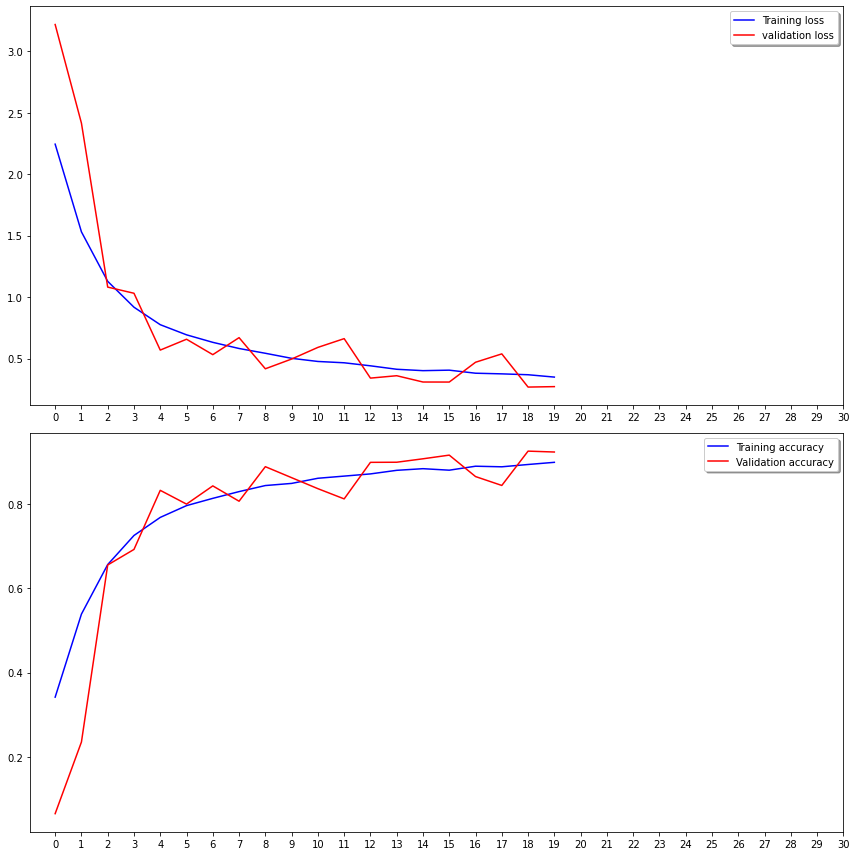

In [23]:
# Gráficos del historial de evaluación del modelo

# El primer gráfico (ax1), traza la curva de pérdida del modelo durante el entrenamiento (color azul) 
# y durante la validación (color rojo) en función del número de épocas. 
# La pérdida es una medida del error del modelo que se quiere minimizar. 

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(31))
ax1.legend(loc='best', shadow=True)

# El segundo gráfico (ax2), traza la curva de precisión del modelo durante el entrenamiento (color azul)
# y durante la validación (color rojo) en función del número de épocas. 
# La precisión es la fracción de predicciones correctas del modelo que se quiere maximizar.

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(31))
ax2.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()